In [1]:
import sqlite3
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data_dir = '../data/'

In [2]:
# collect data from csv
food_inflation_data = pd.read_csv(data_dir+'OCED_USA_FOOD_DATA.csv')
print(food_inflation_data.head(2))

  LOCATION INDICATOR SUBJECT MEASURE FREQUENCY     TIME     Value  Flag Codes
0      USA       CPI    FOOD  AGRWTH         M  1956-01 -1.700680         NaN
1      USA       CPI    FOOD  AGRWTH         M  1956-02 -2.372881         NaN


In [3]:
# plot the food inflation data with time vs inflation
# keep only the USA data
food_inflation_data_USA = food_inflation_data[food_inflation_data['LOCATION'] == 'USA']

time = food_inflation_data_USA['TIME']
time = pd.to_datetime(time)

inflation = food_inflation_data_USA['Value']

# make a new dataframe with only the USA inflation data
USA_inflation_timeseries = pd.DataFrame({'Date': time, 'Inflation': inflation})
print(USA_inflation_timeseries.head(10))

# split the data to use 2023 as the test set
train_data = USA_inflation_timeseries[USA_inflation_timeseries['Date'] < '2023-01-01']
test_data = USA_inflation_timeseries[USA_inflation_timeseries['Date'] >= '2023-01-01']

        Date  Inflation
0 1956-01-01  -1.700680
1 1956-02-01  -2.372881
2 1956-03-01  -2.033898
3 1956-04-01  -1.689189
4 1956-05-01  -0.337838
5 1956-06-01   1.683502
6 1956-07-01   2.341137
7 1956-08-01   1.689189
8 1956-09-01   1.346801
9 1956-10-01   2.380952


In [4]:
# Connect to the data base
conn = sqlite3.connect('../food_inflation_analysis.db')
# save the test data to the sqlite database as a new table
test_data.to_sql('test_data', conn, if_exists='replace', index=False)

# save train data to the sqlite database as a new table named OCED_USA_FOOD_INFLATION
train_data.to_sql('OCED_USA_FOOD_INFLATION', conn, if_exists='replace', index=False)

804

In [5]:
# get the data from the database for analysis
query = '''SELECT * FROM OCED_USA_FOOD_INFLATION'''
cpi_food_data = pd.read_sql(query, conn)
print(cpi_food_data.head(2))
print(cpi_food_data.shape)

                  Date  Inflation
0  1956-01-01 00:00:00  -1.700680
1  1956-02-01 00:00:00  -2.372881
(804, 2)


In [6]:
# close the connection
conn.close()

In [7]:
cpi_food_data['Date'] = pd.to_datetime(cpi_food_data['Date'])
cpi_food_data.set_index('Date', inplace=True)
cpi_food_data.sort_index(inplace=True)
print(cpi_food_data.head(2))
print(cpi_food_data.dtypes)

            Inflation
Date                 
1956-01-01  -1.700680
1956-02-01  -2.372881
Inflation    float64
dtype: object


Text(0.5, 1.0, 'Food Inflation in the USA')

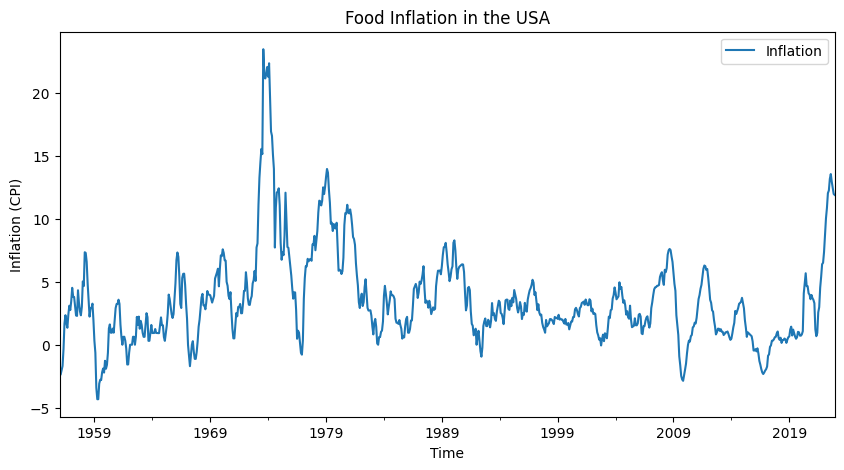

In [8]:
# plot the data
cpi_food_data.plot(figsize=(10, 5))

# add labels and title
plt.xlabel('Time')
plt.ylabel('Inflation (CPI)')
plt.title('Food Inflation in the USA')

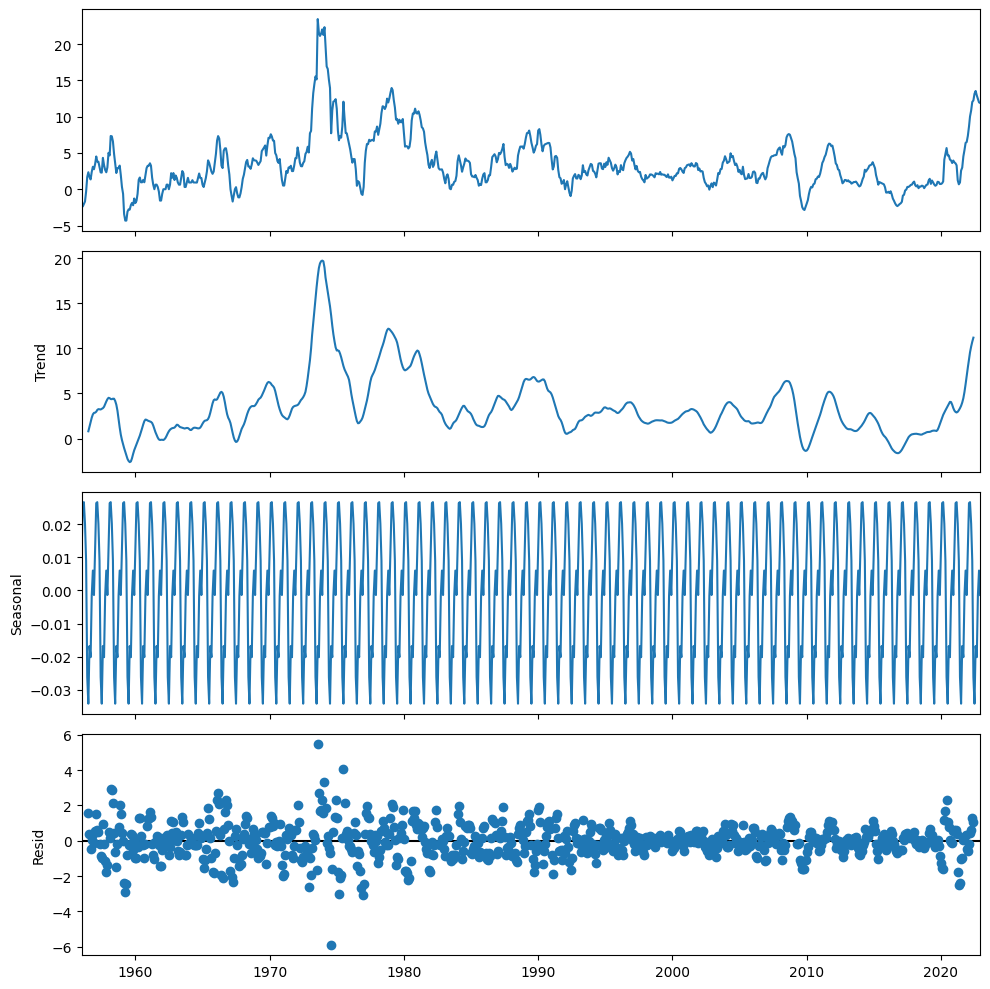

In [9]:
# decompose time series with additive model
decomposition = sm.tsa.seasonal_decompose(cpi_food_data, model = 'additive', period=12)
plt.rcParams['figure.figsize'] = [10,10]
additive_decomp = decomposition.plot()
# get the trend, seasonal and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

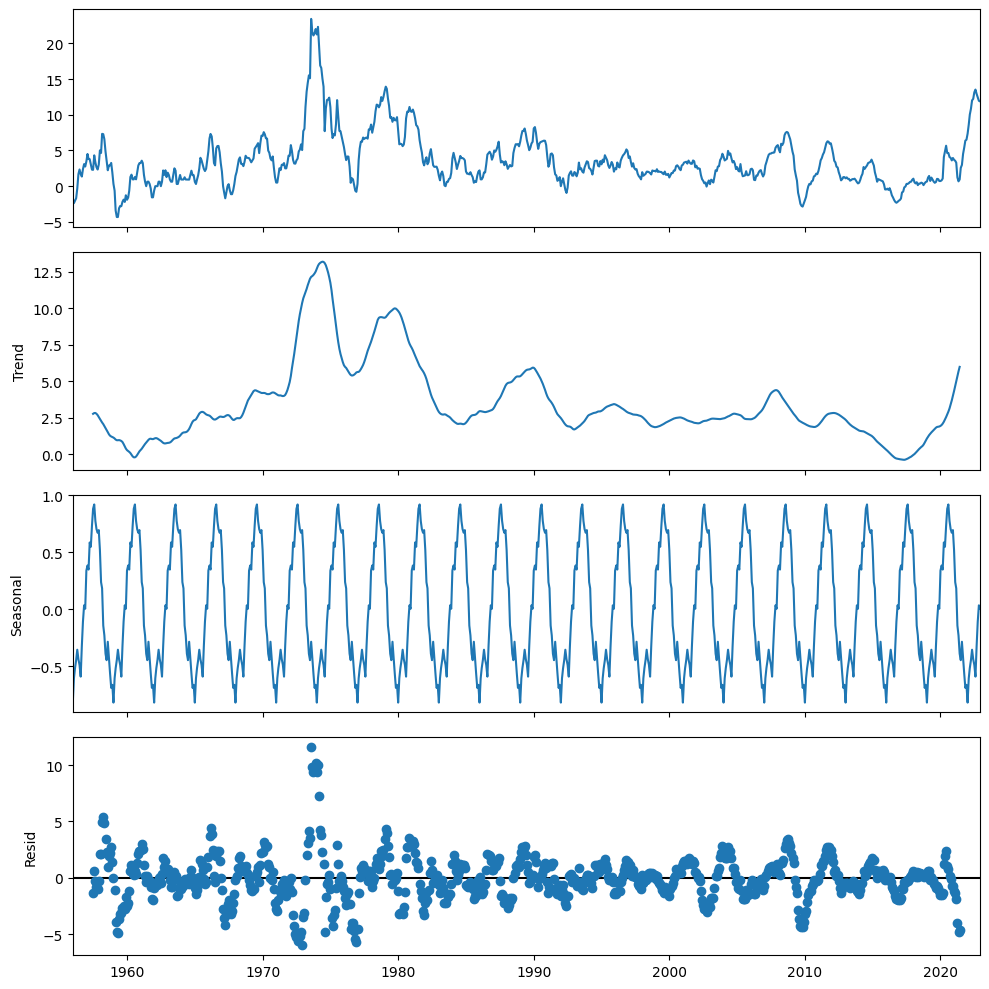

In [15]:
# decompose time series with multiplicative model
decomposition = sm.tsa.seasonal_decompose(cpi_food_data, model = 'additive', period=36)
plt.rcParams['figure.figsize'] = [10,10]
additive_decomp = decomposition.plot()
# get the trend, seasonal and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [11]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)
check_df(cpi_food_data)

##################### Shape #####################
(804, 1)
##################### Types #####################
Inflation    float64
dtype: object
##################### Head #####################
            Inflation
Date                 
1956-01-01  -1.700680
1956-02-01  -2.372881
1956-03-01  -2.033898
##################### Tail #####################
            Inflation
Date                 
2022-10-01   12.43914
2022-11-01   11.95687
2022-12-01   11.88275
##################### NA #####################
Inflation    0
dtype: int64
##################### Quantiles #####################
               0.00      0.05      0.50      0.95       0.99      1.00
Inflation -4.320988 -0.856412  2.802897  11.08269  16.899818  23.43387


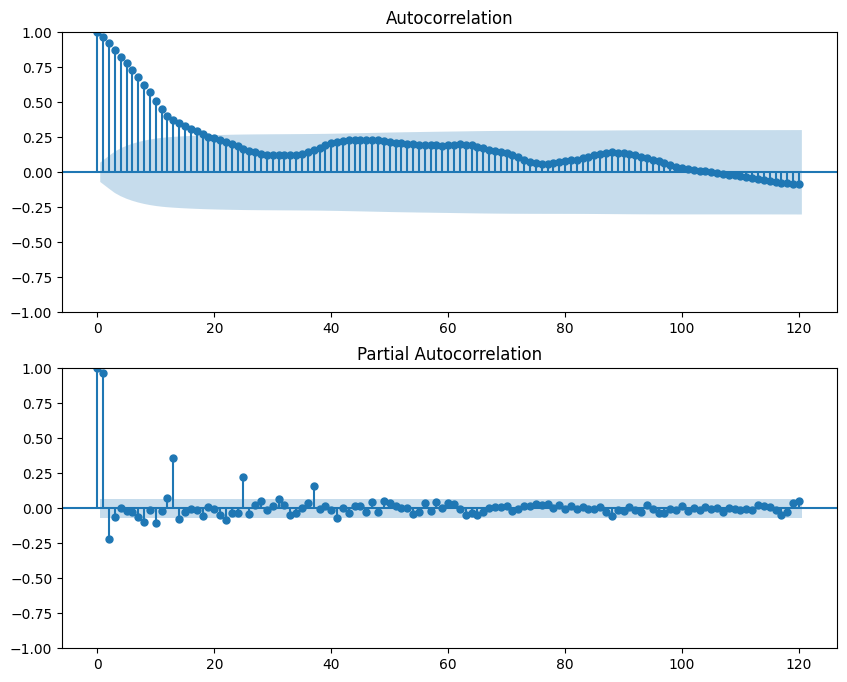

In [16]:
# plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(cpi_food_data, lags=120, ax=ax[0])
sm.graphics.tsa.plot_pacf(cpi_food_data, lags=120, ax=ax[1])
plt.show()


      Inflation
Date           
1990   6.536602
1991   2.674094


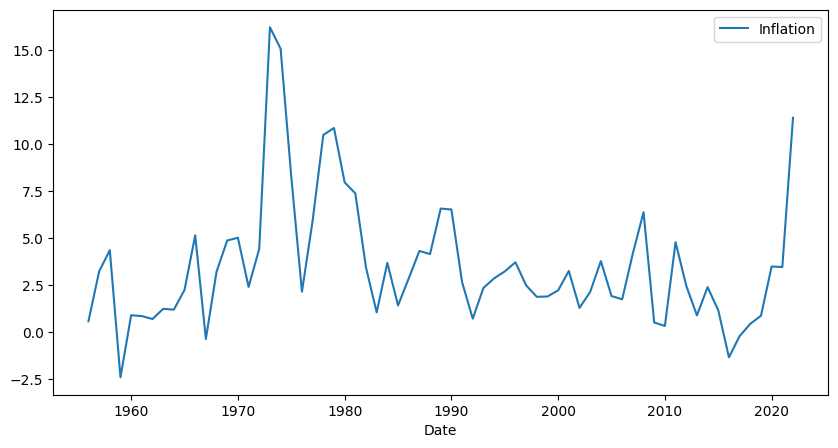

In [17]:
# group the cpi data by year and plot the mean for each year
yearly_cpi = cpi_food_data.groupby(cpi_food_data.index.year).mean()
yearly_cpi.plot(figsize=(10, 5))

# create new dataframe with yearly inflation
yearly_cpi = pd.DataFrame(yearly_cpi['Inflation'])
# get only the years from 1990 to 2021
yearly_cpi = yearly_cpi.loc[1990:2021]
print(yearly_cpi.head(2))
